# Analyze

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import tools.common_functions as cf
import tools.plotting_functions as pf

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
ARRAY_SIZE = ARRAY_W * ARRAY_H

NAME = "table_calibration/2x2_grid_subsampling_validatie_20032024"


In [9]:
original_data = cf.prepare_data_for_fitting(NAME, ARRAY_SIZE, SENSOR_LAG, False)
original_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43192 entries, 2 to 43193
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         43192 non-null  int64  
 1   t_wall        43192 non-null  float64
 2   level_sensor  43192 non-null  float64
 3   X0            43192 non-null  float64
 4   Y0            43192 non-null  float64
 5   Z0            43192 non-null  float64
 6   X1            43192 non-null  float64
 7   Y1            43192 non-null  float64
 8   Z1            43192 non-null  float64
 9   X2            43192 non-null  float64
 10  Y2            43192 non-null  float64
 11  Z2            43192 non-null  float64
 12  X3            43192 non-null  float64
 13  Y3            43192 non-null  float64
 14  Z3            43192 non-null  float64
 15  level_robot   43192 non-null  float64
 16  F_x           43192 non-null  float64
 17  F_y           43192 non-null  float64
 18  F_z           43192 non-nu

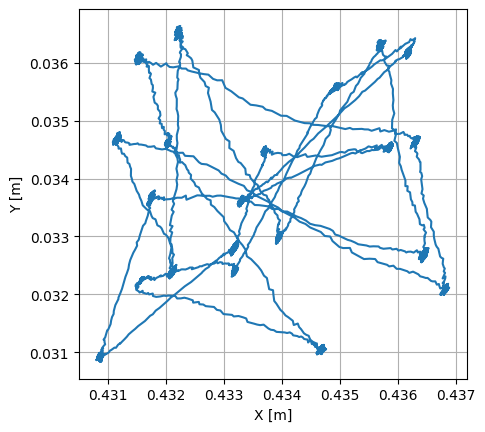

In [10]:
pf.plot_xy(original_data)